#AMO
**The Atlantic Multidecadal Oscillation (AMO)** index is a measure of the **variability in sea surface temperatures** (SSTs) in the **North Atlantic Ocean**. One way to calculate the AMO index is to first calculate the SST anomaly (the difference between the observed SST and the long-term average) and then to apply a low-pass filter to remove high-frequency variability.

1. To use model data from the Coupled Model Intercomparison Project Phase 6 (CMIP6) archive to calculate the AMO index in future climate projections: first download the relevant SST data from the archive. The CMIP6 archive contains data from a large number of climate models, so you would need to select the models and experiments that are most relevant to your research question.

2. Once you have the SST data, calculate the SST anomaly by subtracting the long-term average SST from the observed SST. One way to do this is to calculate the average SST for a specific period, typically the preindustrial control run, and then subtract it from the projected SSTs.

3. Next, apply a low-pass filter to the SST anomaly data in order to remove high-frequency variability. The most common method is using a running mean filter or a bandpass filter.

4. After that, calculate the AMO index by taking the area-weighted average of the SST anomaly in the North Atlantic Ocean. You can use the information from the model to find the boundaries of the North Atlantic and weight the SST anomaly by the area of each grid cell.

# Imports

In [ ]:
# first we have to install some libraries in Colab
!pip install zarr
!pip install gcsfs
!pip uninstall -y shapely 
!pip install shapely==1.8.5 --no-binary shapely
!pip install cartopy==0.18

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 78.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=8e7fb9c11d1c5eb8aff8c3f15a594f1be7b18401ff10fc6684dd749f526b34b8
  Stored in directory: /root/.cache/pip/wheels/a3/d7/75/19cd0d2a893cad4bb0b2b16dd572ad2916d19c0d5ee9612511
Successfully built asciitree
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: shapely 2.0.0
Uninstalling shapely-2.0.0:
  Successfully uninstalled shapely-2.0.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.7/200.7 KB 14.9 MB/s eta 0:00:00
  Installing build

In [ ]:
# set up our libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import zarr
import gcsfs
import numpy as np
from sklearn.decomposition import PCA
from scipy.signal import butter, filtfilt, savgol_filter


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

# notebook display options
xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Browse CMIP6 catalog

In [ ]:
df_full = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_full.sample(5)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
462496,CMIP,NCC,NorCPM1,historical,r3i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/CMIP/NCC/NorCPM1/historical/r...,NaN,20200724
391177,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp370,r14i1p1f1,Omon,fbddtdic,gn,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20191122
482670,PAMIP,NCAR,CESM1-WACCM-SC,pa-piArcSIC,r131i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/PAMIP/NCAR/CESM1-WACCM-SC/pa-...,NaN,20201012
193857,DCPP,CCCma,CanESM5,dcppA-hindcast,r17i1p2f1,Amon,zg,gn,gs://cmip6/DCPP/CCCma/CanESM5/dcppA-hindcast/s...,1984.0,20190429
369452,DCPP,NCAR,CESM1-1-CAM5-CMIP5,dcppA-hindcast,r11i1p1f1,Omon,tos,gr,gs://cmip6/DCPP/NCAR/CESM1-1-CAM5-CMIP5/dcppA-...,1982.0,20191016


# Take a subset

In [ ]:
df_tos = df_full.query("activity_id == 'CMIP' & institution_id == 'IPSL' & source_id=='IPSL-CM6A-LR' & experiment_id=='historical' & member_id=='r1i1p1f1' & table_id == 'Omon' & variable_id == 'tos'")
print(df_tos.shape)
df_tos

(1, 11)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
28719,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803


In [ ]:
# Unique table ids of 'tos' data
#df_tos.table_id.unique()

In [ ]:
# Unique experiment ids of 'tos' data
#df_tos.experiment_id.unique()

# Load data

In [ ]:
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_tos.zstore.values[-1]
print(zstore)
# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Omon/tos/gn/v20180803/


<xarray.Dataset>
Dimensions:         (y: 332, x: 362, nvertex: 4, time: 1980, axis_nbounds: 2)
Coordinates:
    bounds_nav_lat  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    bounds_nav_lon  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    nav_lat         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    nav_lon         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T...
    time_bounds     (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    area            (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    tos             (time, y, x) float32 dask.array<chunksize=(252, 332, 362), meta=np.ndarray>
Attributes: (12/54)
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  historical
    NCO:                    "4.6.0"
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    tracking_id:            hdl:21.14100/01f4d96a-9054-4974-b8dd-4f91e73989d2
    variable_id:            tos
    variant_label:          r1i1p1f1
    status:                 2019-11-10;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/01f4d96a-9054-4974-b8dd-4f91e73989d2
    version_id:             v20180803

In [ ]:
df_area = df_full.query("variable_id == 'areacello' & source_id == 'IPSL-CM6A-LR'")
ds_area = xr.open_zarr(gcs.get_mapper(df_area.zstore.values[0]), consolidated=True)
ds_area

<xarray.Dataset>
Dimensions:         (y: 332, x: 362, nvertex: 4)
Coordinates:
    bounds_nav_lat  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    bounds_nav_lon  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    nav_lat         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    nav_lon         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
Dimensions without coordinates: y, x, nvertex
Data variables:
    area            (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    areacello       (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
Attributes: (12/53)
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  1pctCO2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    ...                     ...
    variable_id:            areacello
    variant_info:           . Information provided by this attribute may in s...
    variant_label:          r1i1p1f1
    status:                 2019-10-27;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/981d757c-4e66-4275-9ab4-e3d8afe5768b
    version_id:             v20180727

In [ ]:
total_area = ds_area.areacello.sum(dim=['y', 'x'])
ds['tos_normalized'] = (ds_area.areacello * ds.tos ) / total_area
ds

<xarray.Dataset>
Dimensions:         (y: 332, x: 362, nvertex: 4, time: 1980, axis_nbounds: 2)
Coordinates:
    bounds_nav_lat  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    bounds_nav_lon  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    nav_lat         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    nav_lon         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T...
    time_bounds     (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    area            (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    tos             (time, y, x) float32 dask.array<chunksize=(252, 332, 362), meta=np.ndarray>
    tos_normalized  (y, x, time) float32 dask.array<chunksize=(332, 362, 252), meta=np.ndarray>
Attributes: (12/54)
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  historical
    NCO:                    "4.6.0"
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    tracking_id:            hdl:21.14100/01f4d96a-9054-4974-b8dd-4f91e73989d2
    variable_id:            tos
    variant_label:          r1i1p1f1
    status:                 2019-11-10;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/01f4d96a-9054-4974-b8dd-4f91e73989d2
    version_id:             v20180803

In [ ]:
ds1 = ds.sel(x=slice(200,280)).sel(y=slice(210,290))

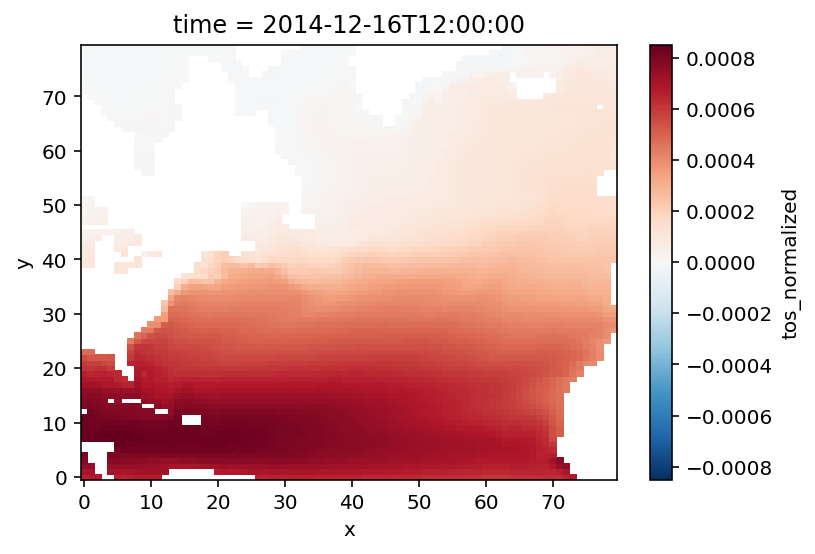

In [ ]:
ds1.tos_normalized.sel(time=ds1.time[-1]).squeeze().plot()

In [ ]:
ds1.tos.shape

(1980, 80, 80)

# Compute AMO Index

In [ ]:
# Calculate the long-term average SST for the preindustrial control run
sst_clim = ds1.sel(time=slice("1856-01-01", "2013-01-01")).tos.mean("time")

# Subtract the long-term average SST from the observed SST to get the SST anomaly
sst_anom = ds1.tos - sst_clim

In [ ]:
sst_anom.shape

(1980, 80, 80)

In [ ]:
# Check for NaN values in the data
if np.isnan(sst_anom).any():
    print("Data contains NaN values.")
    sst_anomaly_data = np.nan_to_num(sst_anom)
    print("NaN values replaced with finite numbers.")
#sst_anomaly_data=np.transpose(sst_anomaly_data,axes=(2,0,1))

Data contains NaN values.
NaN values replaced with finite numbers.


In [ ]:
sst_anomaly_data.shape

(1980, 80, 80)

In [ ]:
# Reshape data to 2D array
sst_anomaly_data_step_2d = np.reshape(sst_anomaly_data, (sst_anomaly_data.shape[0], -1))

# Apply PCA to the 2D SST anomaly data
n_comp=7
pca = PCA(n_components=n_comp)
pca.fit(sst_anomaly_data_step_2d)

PCA(n_components=7)

In [ ]:
X = pca.transform(sst_anomaly_data_step_2d) #X

In [ ]:
areacello_atlantic.shape

(80, 80)

In [ ]:
# "dénormalisation"

pca_comp=np.reshape(pca.components_,(n_comp,sst_anom.shape[1], sst_anom.shape[2]))
pca_components_map=pca_comp.copy()
for i in range(7):
  std_map=np.std(pca.components_[i])
  areacello_atlantic=ds_area.areacello.sel(x=slice(200,280)).sel(y=slice(210,290))
  areacell=np.reshape(areacello_atlantic,(sst_anomaly_data.shape[1],sst_anomaly_data.shape[2]))

  pca_components_map[i] = pca_comp[i] * std_map * total_area.values  / areacell
  X[:,i] = X[:,i] / std_map

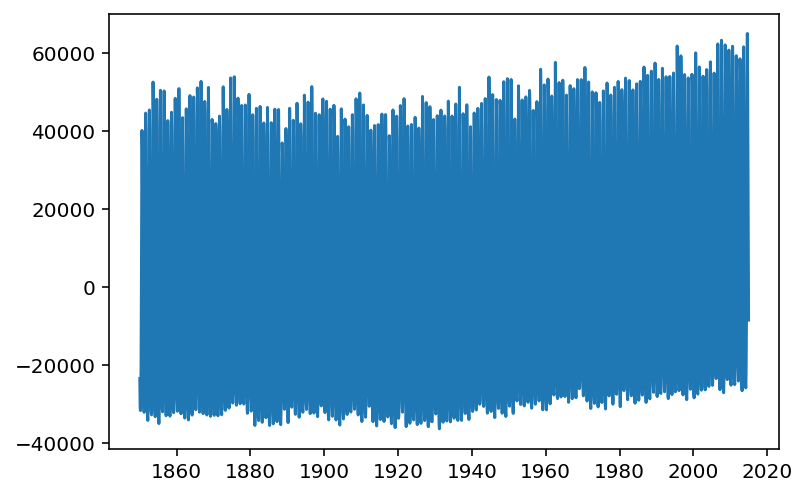

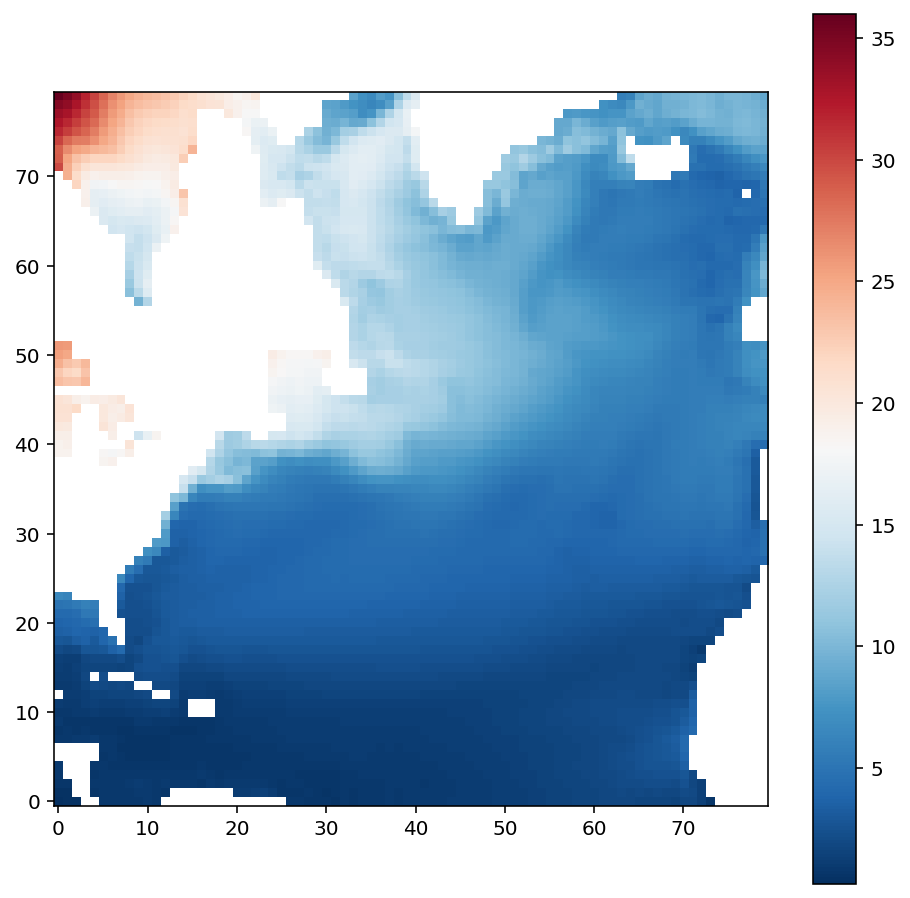

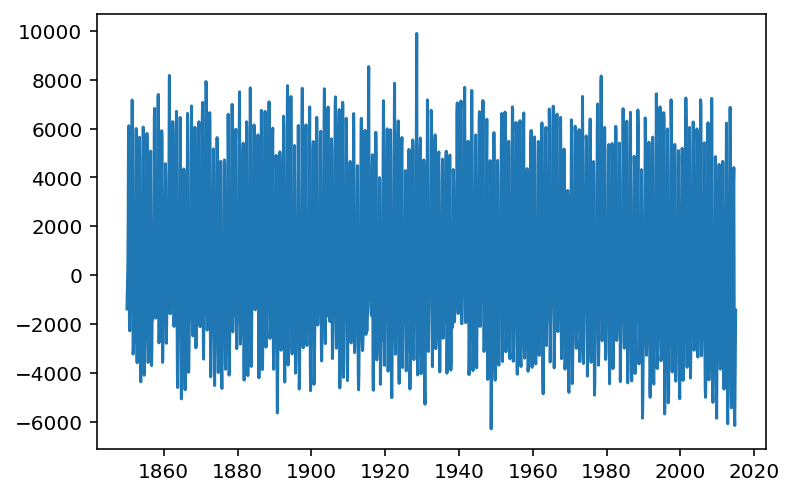

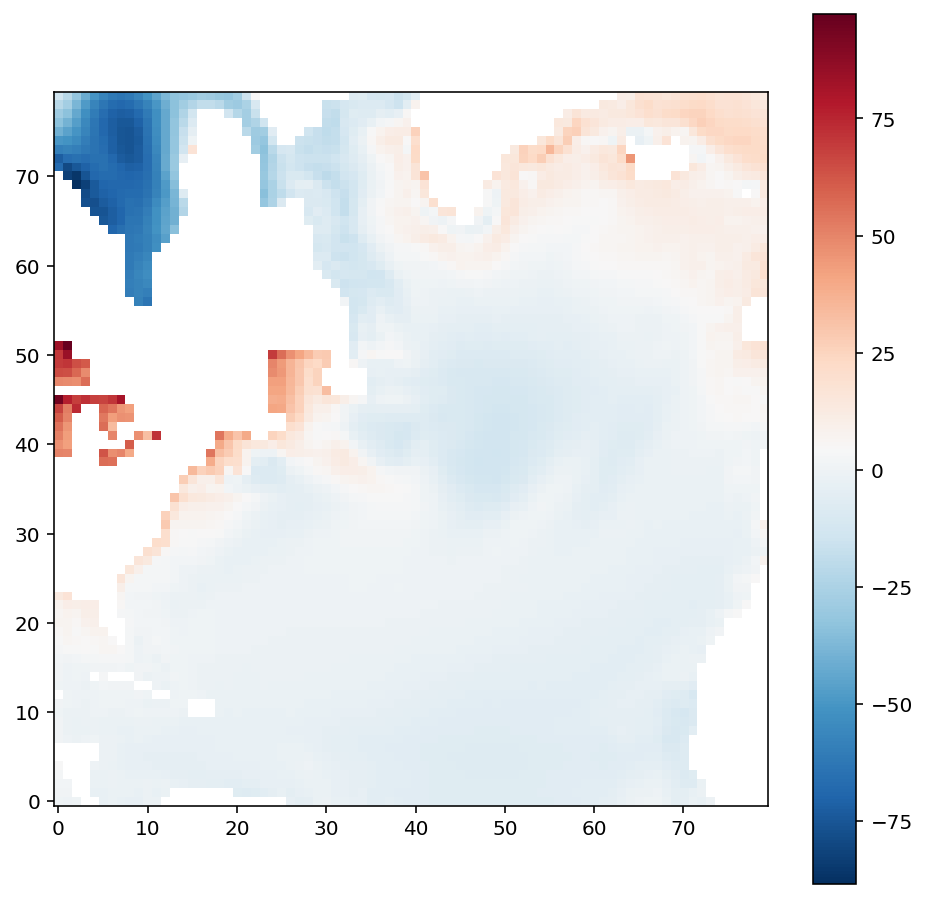

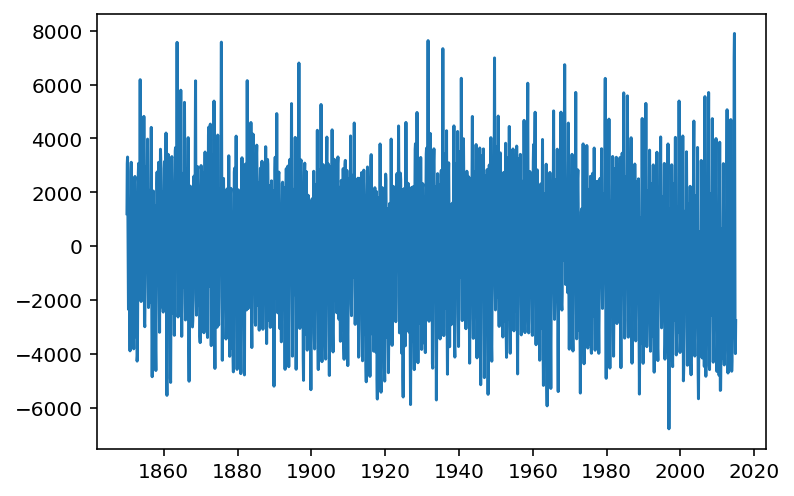

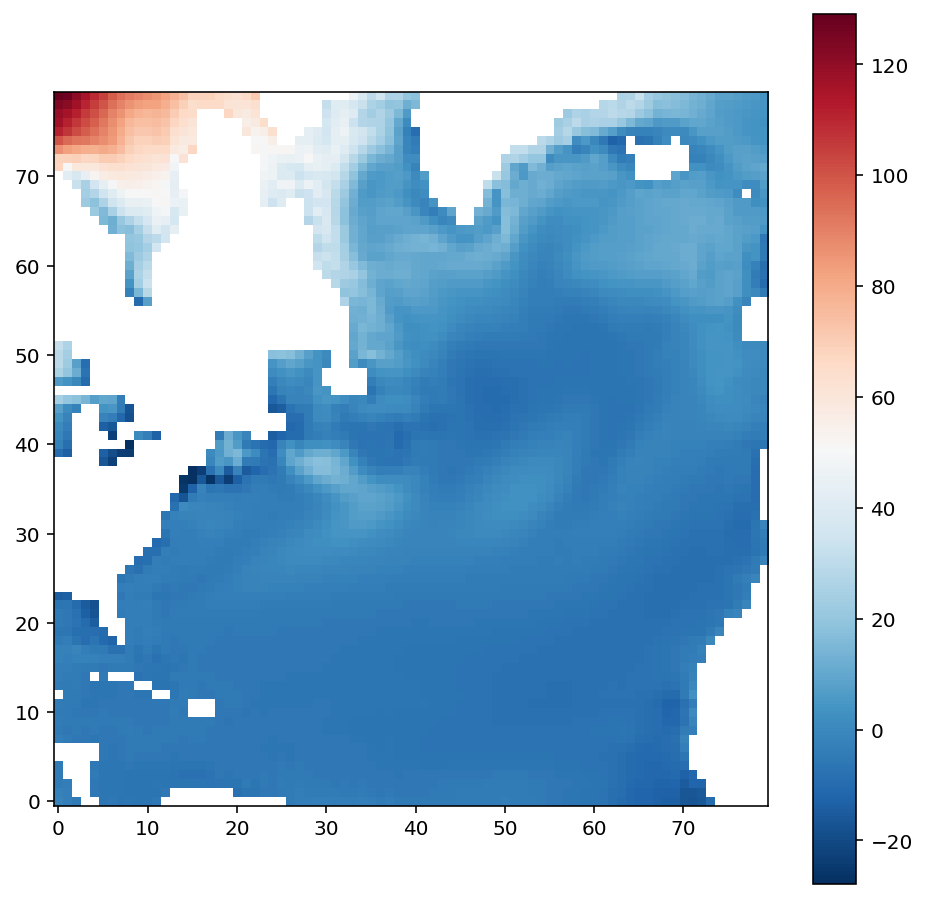

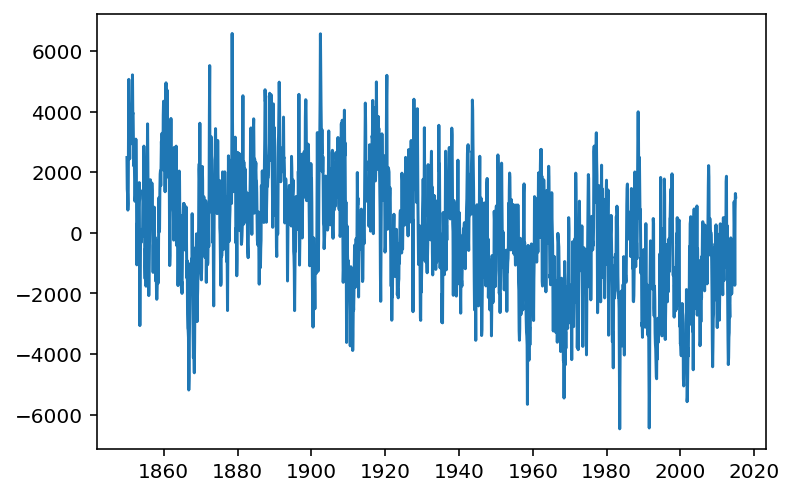

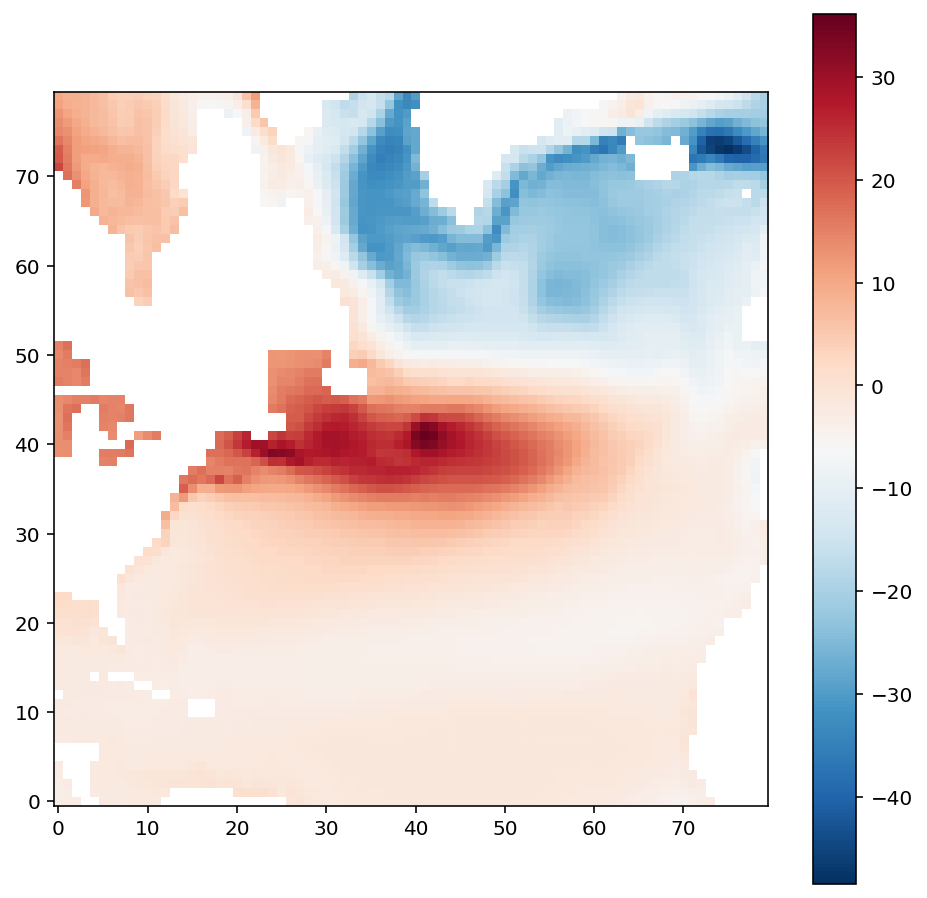

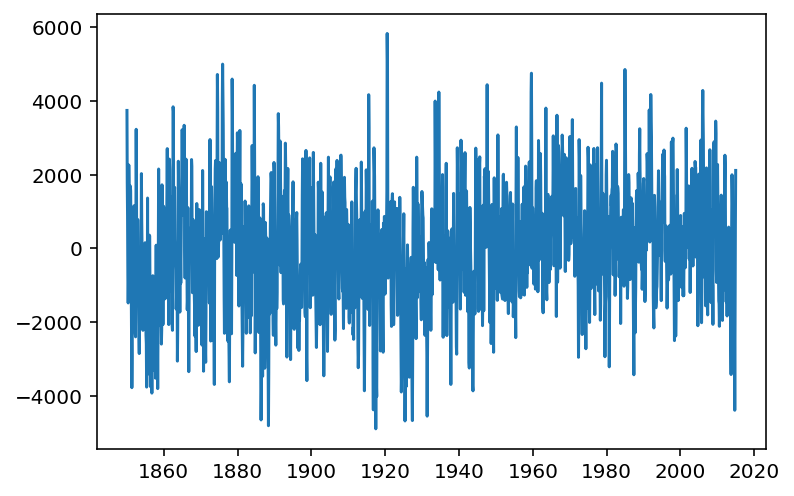

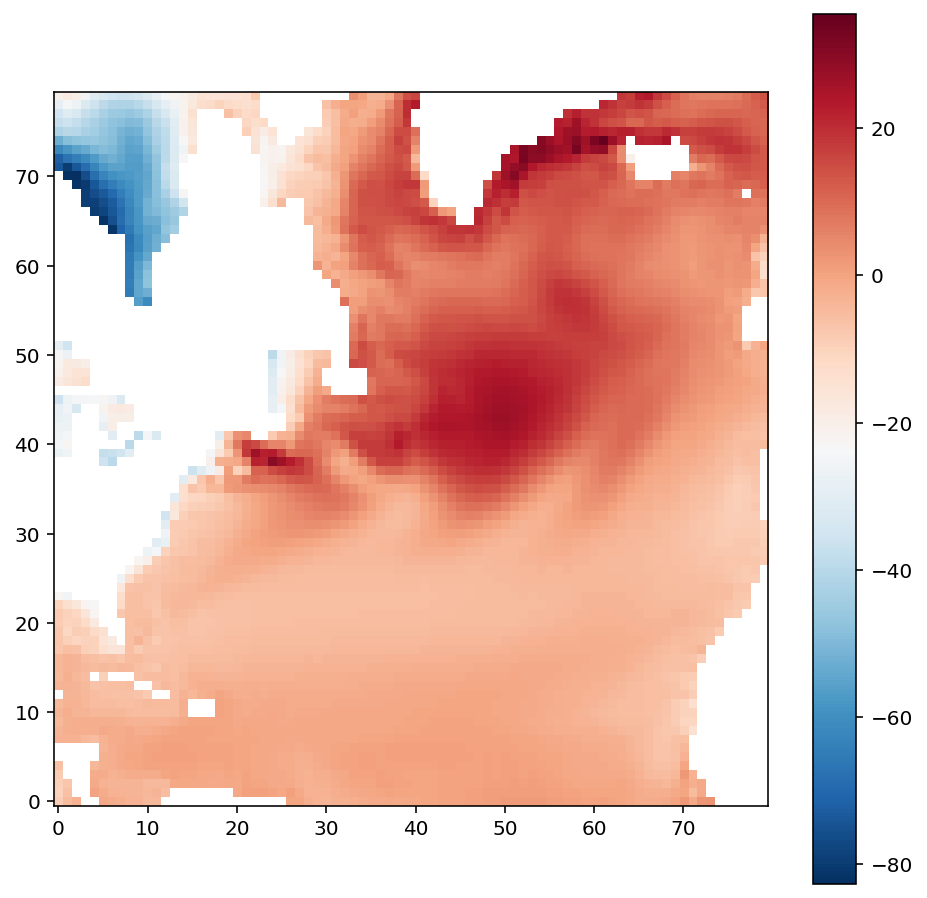

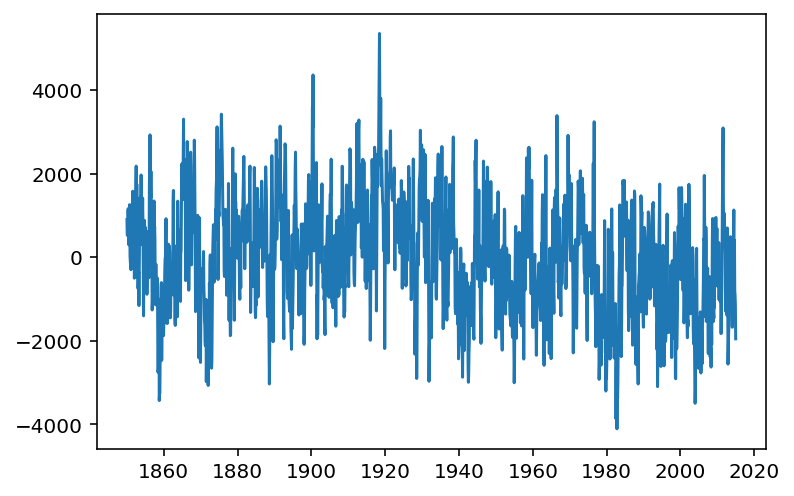

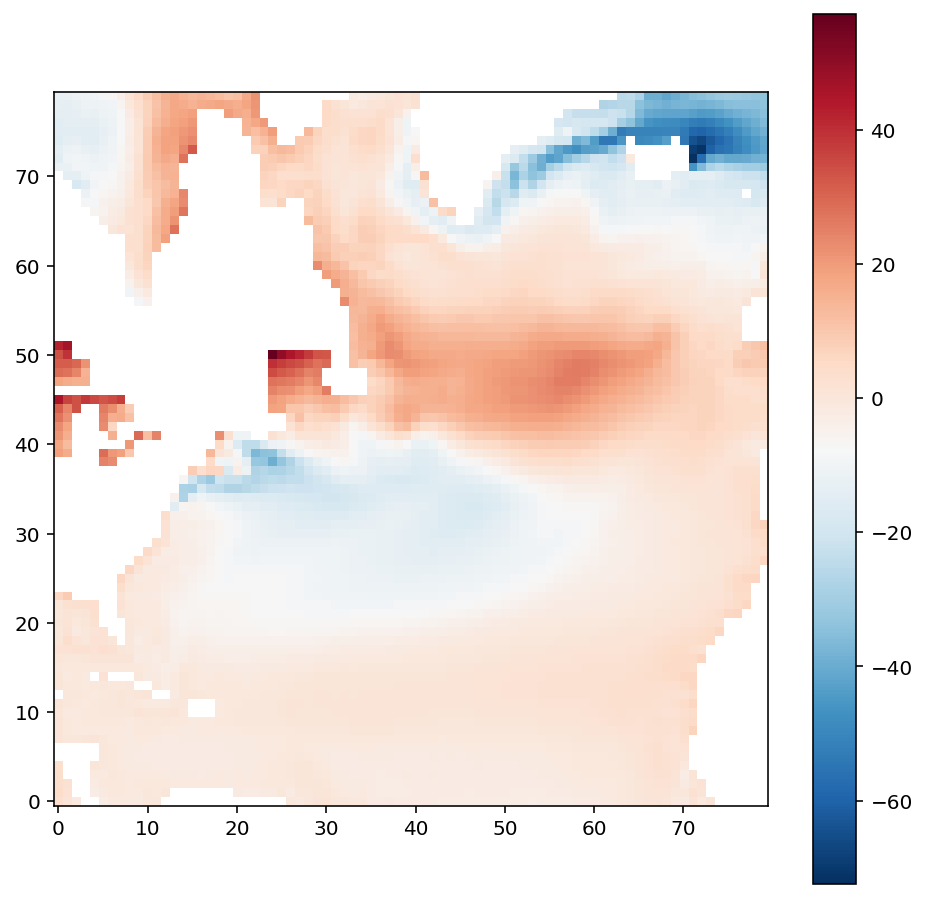

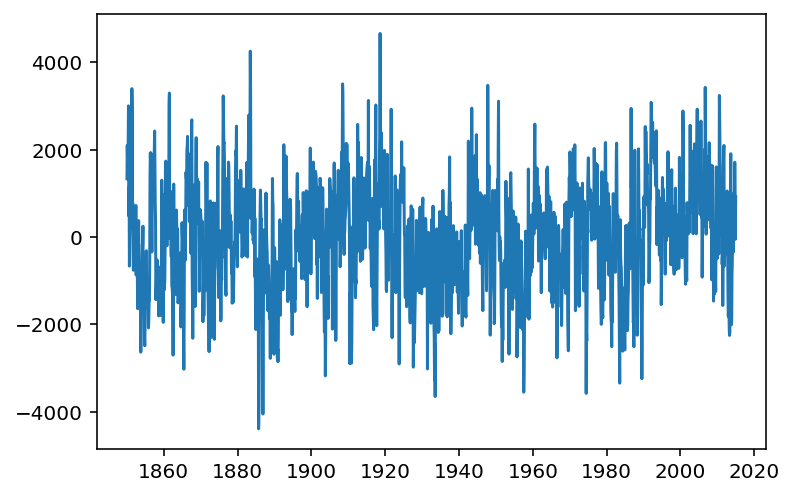

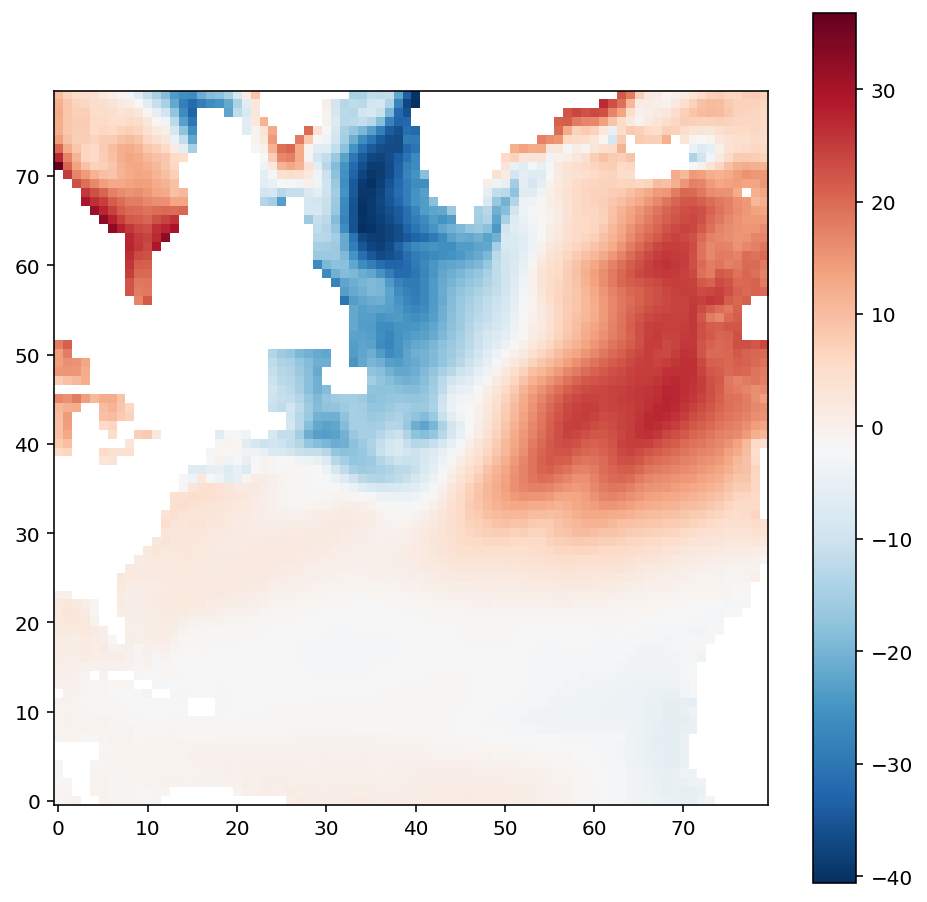

In [ ]:
for i in range(7):
  plt.figure()
  plt.plot(ds1.time, X[:,i])
  fig, ax = plt.subplots(figsize=(8,8))
  im=ax.imshow(pca_components_map[i],cmap='RdBu_r',origin='lower')
  plt.colorbar(im,ax=ax)
  plt.show()

ValueError: ignored

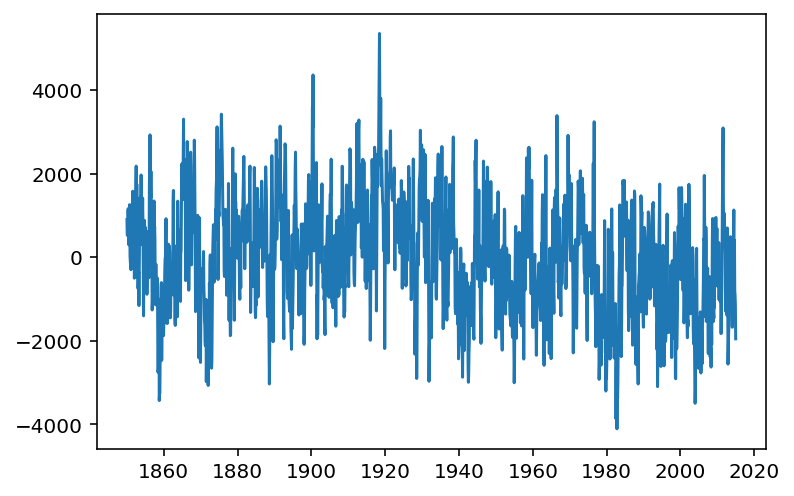

In [ ]:
ds2=( ds1.tos * ds_lonlat.areacello).sum(dim=['y', 'x']) / total_area
plt.figure()
plt.plot(ds1.time, X[:,5])
ds2.load()
ds2.rolling(time=60).mean()..plot(label='12 month rolling mean')

In [ ]:
nvar=np.dot(X[:,4].reshape(-1,1),pca.components_[4].reshape(1,-1))
test=np.reshape(nvar,(1980,80,80))
ds1.tos.values=test
df_area = df_full.query("variable_id == 'areacello' & source_id == 'IPSL-CM6A-LR'")
ds_area = xr.open_zarr(gcs.get_mapper(df_area.zstore.values[0]), consolidated=True)
ds_lonlat=ds_area.sel(x=slice(200,280)).sel(y=slice(210,290))
total_area = ds_lonlat.areacello.sum(dim=['y', 'x'])
to_timeseries = ( ds1.tos * ds_lonlat.areacello).sum(dim=['y', 'x']) / total_area
to_timeseries.load()
#to_timeseries.plot(label='monthly')
to_timeseries.rolling(time=240).mean().plot(label='20 year rolling mean')
plt.legend()
plt.title('AMO')